In [9]:
import pickle
import sklearn
import pandas as pd
import numpy as np

In [21]:
with open("../../saved_models\hate_speech_models_20251201_065246.pkl", "rb") as f:
    artifact = pickle.load(f)

vectorizer = artifact["vectorizer"]
labels = artifact["label_columns"]
features_list = vectorizer.get_feature_names_out()

arovr_lr  = artifact["ovr_lr"]
arovr_svm = artifact["ovr_svm"]
arcc_lr   = artifact["cc_lr"]
arcc_svm  = artifact["cc_svm"]

th_ovr_lr  = np.array(artifact["thresh"]["ovr_lr"])
th_ovr_svm = np.array(artifact["thresh"]["ovr_svm"])
th_cc_lr   = np.array(artifact["thresh"]["cc_lr"])
th_cc_svm  = np.array(artifact["thresh"]["cc_svm"])

MODEL_MAP = {
    "ovr_lr":  (arovr_lr,  th_ovr_lr),
    "ovr_svm": (arovr_svm, th_ovr_svm),
    "cc_lr":   (arcc_lr,   th_cc_lr),
    "cc_svm":  (arcc_svm,  th_cc_svm)
}

def predict_text(text, model_name):
    if model_name not in MODEL_MAP:
        raise ValueError(f"Model '{model_name}' tidak valid. Pilihan: {list(MODEL_MAP.keys())}")

    clf, thresholds = MODEL_MAP[model_name]

    X = pd.Series([text])
    X_vec = vectorizer.transform(X)

    probs = clf.predict_proba(X_vec)

    pred = (probs >= thresholds).astype(int)[0]

    return dict(zip(labels, pred))


In [22]:
from svm_lr_shap import shap_kernel_instance,plot_shap_values

In [23]:
text = "gue ganteng banget dan sangat tampan sekali"

print("OVR LR :", predict_text(text, "ovr_lr"))
print("OVR SVM:", predict_text(text, "ovr_svm"))
print("CC LR  :", predict_text(text, "cc_lr"))
print("CC SVM :", predict_text(text, "cc_svm"))

OVR LR : {'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}
OVR SVM: {'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}
CC LR  : {'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}
CC SVM : {'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}


Fitur aktif (9): ['banget', 'banget dan', 'dan', 'dan sangat', 'ganteng', 'ganteng banget', 'gue', 'sangat', 'sekali']
Menjelaskan label: HS_Individual (Index 0)
Jumlah subset yang dipakai: 500
--------------------------------------------------
Kalimat: gue ganteng banget dan sangat tampan sekali
Penjelasan untuk: HS_Individual
--------------------------------------------------
dan: -0.1019
ganteng: -0.0719
gue: -0.0630
banget: 0.0421
sangat: -0.0411
ganteng banget: 0.0260
banget dan: -0.0247
dan sangat: -0.0188
sekali: 0.0082

Baseline (E[f(x)]): 0.23825581558504239
Baseline + ΣKernelSHAP: -0.006953945815604046
Prediksi Asli f(x): 0.012399144611908624
Total waktu SHAP: 3.5675 detik


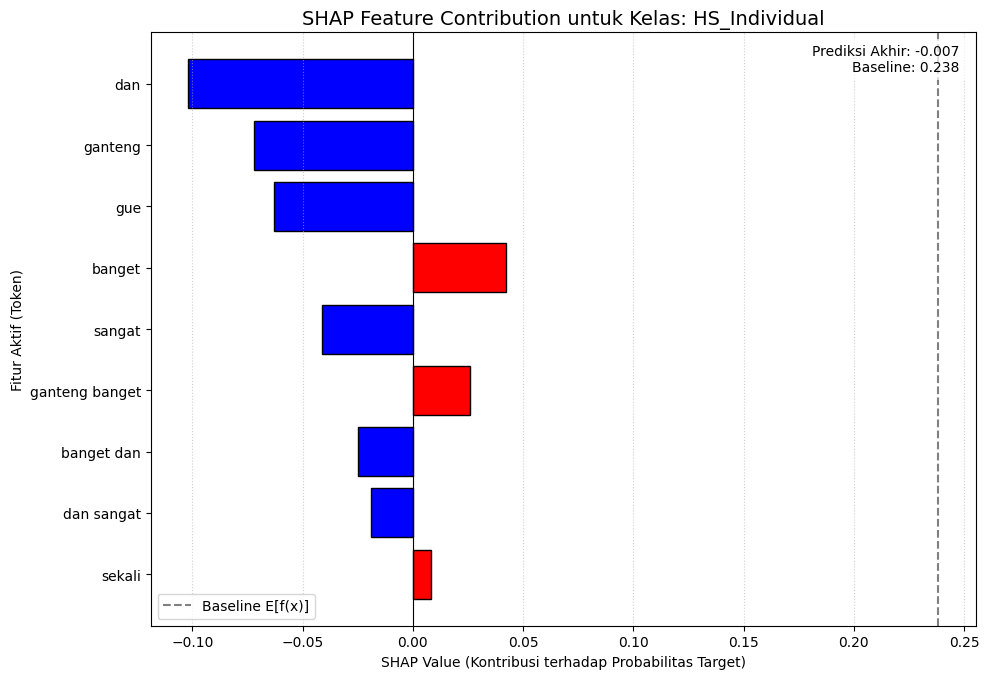

In [25]:
clf, th = MODEL_MAP["cc_svm"]
target_label = "HS_Individual"

base_value, shap_values, fitur_aktif = shap_kernel_instance(
    text,
    vectorizer,
    clf,
    features_list,
    labels,
    target_label,
    num_samples=500
)

plot_shap_values(base_value, shap_values, fitur_aktif, text, target_label)